In [14]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import os
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [15]:
FORESIGHT_DIRECTORY = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
DATA_PROCESSED_DIRECTORY = os.path.join(FORESIGHT_DIRECTORY, "data", "processed")

# Nombre de los archivos
TRAIN_FILENAME = "X_train.csv"
TEST_FILENAME = "X_test.csv"

# Rutas completas
TRAIN_PATH = os.path.join(DATA_PROCESSED_DIRECTORY, TRAIN_FILENAME)
TEST_PATH = os.path.join(DATA_PROCESSED_DIRECTORY, TEST_FILENAME)

In [16]:
X_test = pd.read_csv(TEST_PATH)
X_train = pd.read_csv(TRAIN_PATH)

In [17]:
# Definir función de mapeo
def map_difficulty(val):
    if val == 0:
        return 0
    elif val in [1, 2]:
        return 1
    elif val in [3, 4, 5, 6]:
        return 2
    elif val in [7, 8]:
        return 3
    elif val == 9:
        return 4

# Aplicar la función
#X_train["difficulty"] = X_train["difficulty"].apply(map_difficulty)
#X_test["difficulty"] = X_test["difficulty"].apply(map_difficulty)

In [18]:
y_train = X_train['difficulty']
X_train = X_train.drop('difficulty', axis=1)
y_test = X_test['difficulty']
X_test = X_test.drop('difficulty', axis=1)

In [19]:


# Entrena PCA (sin reducir aún)
pca = PCA()
pca.fit(X_train)  # X_train debe estar escalado si aún no lo está


PCA()

In [20]:


# DataFrame con cargas de cada variable en cada componente
loadings = pd.DataFrame(
    np.abs(pca.components_),  # valor absoluto para importancia
    columns=X_train.columns,
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)


In [21]:
# Top 10 columnas que más contribuyen al primer componente
top_pc1 = loadings.loc["PC1"].sort_values(ascending=False).head(10)
print("Top columnas en PC1:")
print(top_pc1)


Top columnas en PC1:
monster4_hp_max    0.623473
monster5_hp_max    0.572000
monster6_hp_max    0.426925
monster7_hp_max    0.228790
monster5_ac        0.118942
monster4_ac        0.114103
monster6_ac        0.097562
monster7_ac        0.054940
monster4_cr        0.035976
monster5_cr        0.033968
Name: PC1, dtype: float64


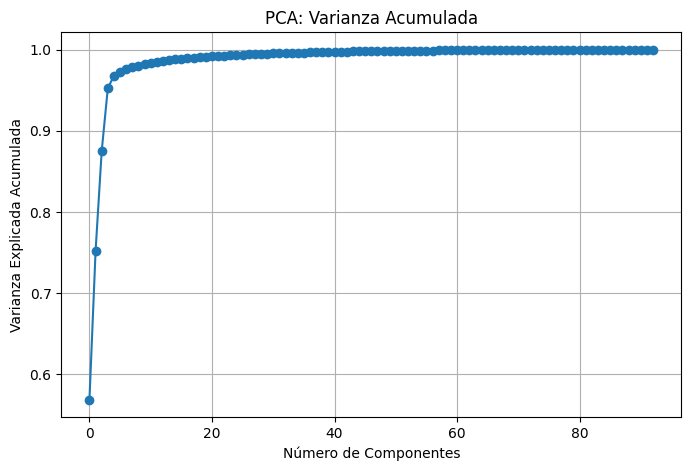

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('PCA: Varianza Acumulada')
plt.grid(True)
plt.show()


In [23]:
# Reducimos a, por ejemplo, 10 componentes
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


# Definir el modelo base
knn = KNeighborsClassifier()

# Definir los hiperparámetros a probar
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'kd_tree', 'ball_tree'],
    'leaf_size': [20, 30, 40, 50],
    'p': [1, 2],  # 1 = manhattan, 2 = euclidean
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# GridSearch con validación cruzada
grid_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=500,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entrenar GridSearch con datos PCA
grid_search.fit(X_train_pca, y_train)

# Usar el mejor modelo
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_pca)

# Evaluar
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] END algorithm=kd_tree, leaf_size=20, metric=euclidean, n_neighbors=7, p=2, weights=distance; total time=   9.8s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=13, p=2, weights=distance; total time=  12.4s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=13, p=2, weights=distance; total time=  13.2s
[CV] END algorithm=kd_tree, leaf_size=20, metric=euclidean, n_neighbors=13, p=1, weights=distance; total time=  13.2s
[CV] END algorithm=kd_tree, leaf_size=20, metric=euclidean, n_neighbors=13, p=1, weights=distance; total time=  13.3s
[CV] END algorithm=kd_tree, leaf_size=20, metric=euclidean, n_neighbors=13, p=1, weights=distance; total time=  13.3s
[CV] END algorithm=auto, leaf_size=20, metric=euclidean, n_neighbors=13, p=2, weights=distance; total time=  13.5s
[CV] END algorithm=auto, leaf_size=40, metric=minkowski, n_neighbors=5, p=2, weights=uniform; total time=  15.2s
[CV] EN

In [24]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.5671


In [25]:
from sklearn.metrics import confusion_matrix

# Supongamos que ya hiciste predicciones
# y_test: etiquetas verdaderas
# y_pred: etiquetas predichas por tu modelo

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 4200  3550   138    21     7     8    10     7     8     8]
 [ 2596 19995  3260   213    40   116    99   104    73     8]
 [  165  4526  5480   694   172   356   330   297   113    18]
 [   34   556  1080   475   108   295   249   195    65     5]
 [    7   156   278   175    78   133   150   109    36     3]
 [   18   319   530   289   123   369   451   441   149    20]
 [   16   302   459   255   102   453   819  1096   422    44]
 [   23   260   380   144    76   318   941  2742  2250   149]
 [    7   120   153    38    26   120   354  1947 12367  2589]
 [    8    14    26     4     1    15    30   160  2746  4516]]


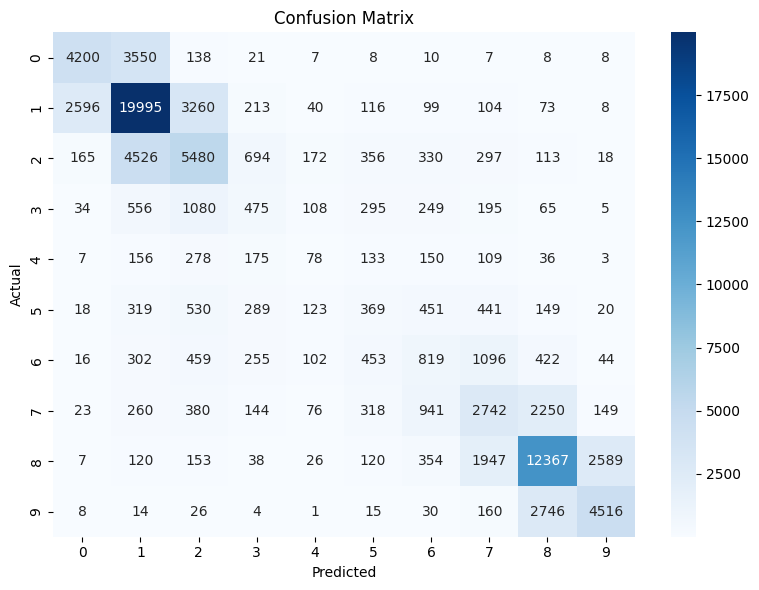

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()